In [72]:
import gym
from gym import spaces, logger
from gym.utils import seeding
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

In [73]:
# Define the Segway environment
class SegwayEnv(gym.Env):

    def __init__(self):
        self.gravity = 9.8
        self.mass_cart = 1.0
        self.mass_pole = 0.4
        self.total_mass = self.mass_cart + self.mass_pole
        self.length = 0.5  # half the pole's length
        self.polemass_length = self.mass_pole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 15 degrees
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max],
            dtype=np.float32)

        self.action_space = spaces.Box(-self.force_mag, self.force_mag, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None
        self.steps_beyond_done = None
        self.figure, self.ax = None, None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = action[0]
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # Dynamics for a Segway-like vehicle
        torque = force * self.length  # Torque proportional to force and distance from pivot

        # Equations of motion
        thetaacc = (self.gravity * sintheta + costheta * torque / self.length -
                    self.polemass_length * theta_dot**2 * sintheta / self.length) / \
                   (self.length * (4.0/3.0 - self.mass_pole * costheta**2 / self.total_mass))

        xacc = (torque - self.polemass_length * thetaacc * costheta) / self.total_mass

        # Update the state variables
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = (x, x_dot, theta, theta_dot)

        done = x < -self.x_threshold \
               or x > self.x_threshold \
               or theta < -self.theta_threshold_radians \
               or theta > self.theta_threshold_radians

        done = bool(done)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width / world_width
        carty = 100  # Cart position on y-axis
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.figure is None:
            self.figure, self.ax = plt.subplots()
            self.ax.set_xlim(0, screen_width)
            self.ax.set_ylim(0, screen_height)
            # dont show axis
            self.ax.axis('off')
            self.cart = plt.Rectangle((0, 0), cartwidth, cartheight, fill=True, color='blue')
            self.ax.add_patch(self.cart)
            self.pole = plt.Rectangle((0, 0), polewidth, polelen, fill=True, color='red')
            self.ax.add_patch(self.pole)

        # Update positions
        cartx = self.state[0] * scale + screen_width / 2.0 - cartwidth / 2.0
        self.cart.set_xy((cartx, carty))
        self.pole.set_xy((cartx + cartwidth / 2.0 - polewidth / 2.0, carty + cartheight))

        # Rotate the pole
        pole_angle = -self.state[2]
        t = mpl.transforms.Affine2D().rotate_deg_around(cartx + cartwidth / 2.0, carty + cartheight, np.rad2deg(pole_angle)) + self.ax.transData
        self.pole.set_transform(t)

        # Redraw the figure
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()
        plt.pause(0.01)  # Pause for a brief moment to update plots

    def close(self):
        # if self.viewer:
        #     self.viewer.close()
        #     self.viewer = None
        if self.figure:
            plt.close(self.figure)

In [74]:
env = SegwayEnv()

In [75]:
# Hyperparameters
EPISODES = 10000
DISCOUNT = 0.95
EPISODE_DISPLAY = 500
LEARNING_RATE = 0.25
EPSILON = 0.2

In [76]:
# Q-Table dimensions
theta_minmax = env.observation_space.high[2]
theta_dot_minmax = math.radians(50)
theta_state_size = 50
theta_dot_state_size = 50
action_size = 10  # Number of discrete actions

# Initialize Q-table with dimensions (theta_state_size, theta_dot_state_size, action_size)
Q_TABLE = np.random.randn(theta_state_size, theta_dot_state_size, action_size)

In [77]:
# For stats
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}
theta_deviations = []  # List to store deviations

In [78]:
# Discretize state function
def discretised_state(state):
    discrete_state = np.array([0, 0])
    theta_window = (theta_minmax - (-theta_minmax)) / theta_state_size
    discrete_state[0] = (state[2] - (-theta_minmax)) // theta_window
    discrete_state[0] = min(theta_state_size - 1, max(0, discrete_state[0]))

    theta_dot_window = (theta_dot_minmax - (-theta_dot_minmax)) / theta_dot_state_size
    discrete_state[1] = (state[3] - (-theta_dot_minmax)) // theta_dot_window
    discrete_state[1] = min(theta_dot_state_size - 1, max(0, discrete_state[1]))

    return tuple(discrete_state.astype(int))

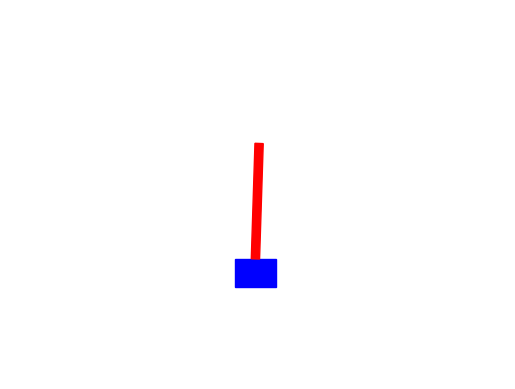

Episode:0 avg:14.0 min:14.0 max:14.0
action:5.0
Episode:500 avg:13.328 min:9.0 max:37.0
action:0.0
Episode:1000 avg:13.24 min:9.0 max:32.0
action:6.0
Episode:1500 avg:13.274 min:9.0 max:37.0
action:5.0
Episode:2000 avg:13.536 min:9.0 max:39.0
action:5.0
Episode:2500 avg:13.22 min:9.0 max:27.0
action:6.0
Episode:3000 avg:13.082 min:8.0 max:30.0
action:5.0
Episode:3500 avg:13.516 min:9.0 max:33.0
action:8.208039496619307
Episode:4000 avg:13.296 min:9.0 max:33.0
action:0.0
Episode:4500 avg:13.518 min:8.0 max:26.0
action:6.0
Episode:5000 avg:12.85 min:8.0 max:37.0
action:5.0
Episode:5500 avg:13.628 min:8.0 max:32.0
action:6.0
Episode:6000 avg:13.058 min:9.0 max:36.0
action:6.0
Episode:6500 avg:13.164 min:8.0 max:32.0
action:5.0
Episode:7000 avg:13.534 min:8.0 max:37.0
action:-4.505795277497418
Episode:7500 avg:13.202 min:8.0 max:30.0
action:-3.763938280022467
Episode:8000 avg:13.512 min:8.0 max:35.0
action:-1.8493588333255584
Episode:8500 avg:14.43 min:9.0 max:55.0
action:5.0
Episode:9000 

In [79]:
# SARSA algorithm
for episode in range(EPISODES):
    episode_reward = 0
    done = False

    initial_state = env.reset()
    initial_theta = initial_state[0]  # Record the initial theta

    if episode % EPISODE_DISPLAY == 0:
        render_state = True
    else:
        render_state = False

    curr_discrete_state = discretised_state(env.reset())
    if np.random.random() > EPSILON:
        action = np.argmax(Q_TABLE[curr_discrete_state])
    else:
        action = np.random.uniform(env.action_space.low[0], env.action_space.high[0])  # Sample action uniformly from the action space

    while not done:
        # Clip the action to ensure it falls within the valid range
        action = np.clip(action, env.action_space.low[0], env.action_space.high[0])

        new_state, reward, done, _ = env.step([action])  # Pass the action as a list
        new_discrete_state = discretised_state(new_state)

        if np.random.random() > EPSILON:
            new_action = np.argmax(Q_TABLE[new_discrete_state])
        else:
            new_action = np.random.uniform(env.action_space.low[0], env.action_space.high[0])

        # Clip the new action as well
        new_action = np.clip(new_action, env.action_space.low[0], env.action_space.high[0])

        if render_state:
            env.render()

        if not done:
            current_q = Q_TABLE[curr_discrete_state + (int(action),)]   # Convert action to integer
            max_future_q = Q_TABLE[new_discrete_state + (int(new_action),)]  # Convert new_action to integer
            new_q = current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q - current_q)
            Q_TABLE[curr_discrete_state + (int(action),)] = new_q  # Convert action to integer

        curr_discrete_state = new_discrete_state
        action = new_action

        episode_reward += reward

    final_theta = new_state[0]  # Record the final theta
    theta_deviations.append(final_theta - initial_theta)  # Compute the deviation

    ep_rewards.append(episode_reward)

    if not episode % EPISODE_DISPLAY:
        avg_reward = sum(ep_rewards[-EPISODE_DISPLAY:]) / len(ep_rewards[-EPISODE_DISPLAY:])
        ep_rewards_table['ep'].append(episode)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-EPISODE_DISPLAY:]))
        ep_rewards_table['max'].append(max(ep_rewards[-EPISODE_DISPLAY:]))
        print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-EPISODE_DISPLAY:])} max:{max(ep_rewards[-EPISODE_DISPLAY:])}")
        print(f"action:{action}")

In [80]:
env.close()

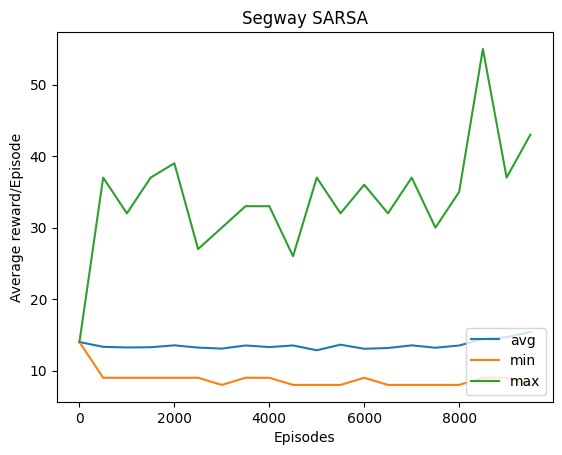

In [81]:
plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
plt.legend(loc=4)  # bottom right
plt.title('Segway SARSA')
plt.ylabel('Average reward/Episode')
plt.xlabel('Episodes')
plt.show()

In [82]:
# Calculate the rolling average of theta deviations
window_size = 50  # Window size for the rolling average
rolling_avg = np.convolve(theta_deviations, np.ones(window_size)/window_size, mode='valid')

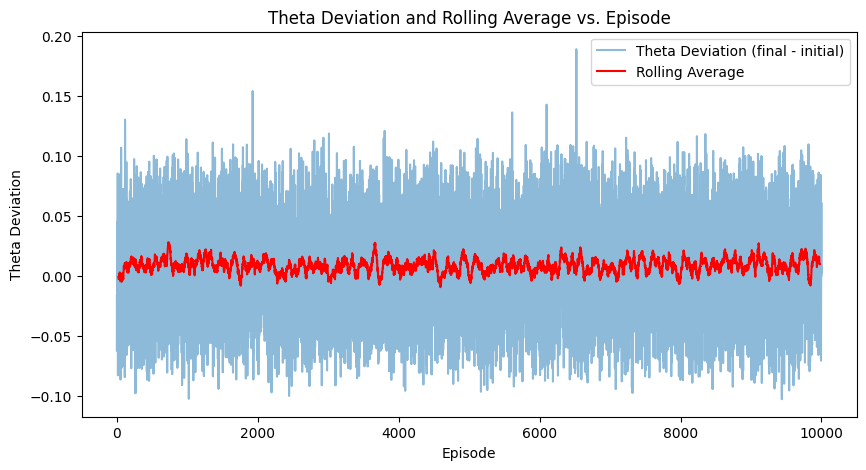

In [83]:
# Plot the deviation and rolling average
plt.figure(figsize=(10, 5))
plt.plot(theta_deviations, label='Theta Deviation (final - initial)', alpha=0.5)
plt.plot(range(window_size // 2, len(theta_deviations) - window_size // 2 + 1), rolling_avg, label='Rolling Average', color='red')
plt.xlabel('Episode')
plt.ylabel('Theta Deviation')
plt.title('Theta Deviation and Rolling Average vs. Episode')
plt.legend()
plt.show()